In [6]:
import numpy as np
import pandas as pd

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
admissions = pd.read_csv("./files/mimiciii/1.4/ADMISSIONS.csv")

In [4]:
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [5]:
admissions.dtypes

ROW_ID                   int64
SUBJECT_ID               int64
HADM_ID                  int64
ADMITTIME               object
DISCHTIME               object
DEATHTIME               object
ADMISSION_TYPE          object
ADMISSION_LOCATION      object
DISCHARGE_LOCATION      object
INSURANCE               object
LANGUAGE                object
RELIGION                object
MARITAL_STATUS          object
ETHNICITY               object
EDREGTIME               object
EDOUTTIME               object
DIAGNOSIS               object
HOSPITAL_EXPIRE_FLAG     int64
HAS_CHARTEVENTS_DATA     int64
dtype: object

In [18]:
admissions.shape

(58976, 19)

In [12]:
admissions.ADMITTIME.head()

0    2196-04-09 12:26:00
1    2153-09-03 07:15:00
2    2157-10-18 19:34:00
3    2139-06-06 16:14:00
4    2160-11-02 02:06:00
Name: ADMITTIME, dtype: object

In [5]:
admissions["ADMITTIME"] = pd.to_datetime(admissions.ADMITTIME)

In [6]:
admissions["DISCHTIME"] = pd.to_datetime(admissions.DISCHTIME)

### Create the primary outcome variable
- The length of stay is the time from the admission to the discharge from hospital.
- The data contains protected health information so the actual admission time and discharge time are shifted.
- The distribution of the outcome variable is highly skewed.
    - Dichotomize the outcome variable (imbalanced classification problem).
    - Keep the continuous variable and find optimal methods to model skewed distribution.

In [7]:
admissions["LOS"] = admissions.DISCHTIME-admissions.ADMITTIME

In [9]:
admissions.LOS.head()

0   1 days 03:28:00
1   5 days 11:55:00
2   6 days 18:26:00
3   2 days 20:34:00
4   3 days 12:49:00
Name: LOS, dtype: timedelta64[ns]

In [14]:
los_count = admissions.groupby(admissions['LOS'].dt.days).LOS.count()

<BarContainer object of 162 artists>

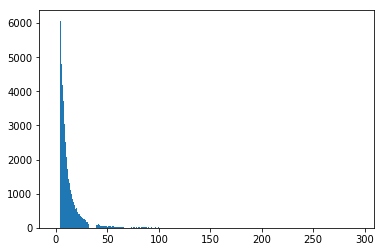

In [24]:
plt.bar(los_count.index, los_count)

In [14]:
admissions.ADMISSION_TYPE.astype("category").value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

### Discharge Location
- Most of the patients are discharged to home/home health care/hospice-home/home with home IV provider.
- Some of the patients are discharged to SNF (Skilled Nursing Facility). It can also be a secondary outcome variable.
- Some of the patients are discharged to hospice-medical facility.

In [16]:
admissions.DISCHARGE_LOCATION.astype("category").value_counts()

HOME                         18962
HOME HEALTH CARE             13963
SNF                           7705
REHAB/DISTINCT PART HOSP      6429
DEAD/EXPIRED                  5854
LONG TERM CARE HOSPITAL       2305
SHORT TERM HOSPITAL           1534
DISC-TRAN CANCER/CHLDRN H      669
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   402
LEFT AGAINST MEDICAL ADVI      365
HOSPICE-MEDICAL FACILITY       153
HOME WITH HOME IV PROVIDR       67
OTHER FACILITY                  63
ICF                             47
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64

### Potential predictos
- Insurance, Language, ethnicity, admission_type, marital_status, diagnosis, age, sex
- Diagnosis variable contains too many levels. 
    - Delete some levels with too less patients.
    - Combine some levels, such as diagnosis starting with nausea and subtypes of coronary artery disease.
- After combining the patients table with the admission table, there is no missing data.

In [19]:
admissions.DIAGNOSIS.astype("category").value_counts()

NEWBORN                                                      7823
PNEUMONIA                                                    1566
SEPSIS                                                       1184
CONGESTIVE HEART FAILURE                                      928
CORONARY ARTERY DISEASE                                       840
CHEST PAIN                                                    778
INTRACRANIAL HEMORRHAGE                                       713
ALTERED MENTAL STATUS                                         712
GASTROINTESTINAL BLEED                                        686
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA     583
UPPER GI BLEED                                                580
ABDOMINAL PAIN                                                554
FEVER                                                         510
DIABETIC KETOACIDOSIS                                         462
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT/SDA      450
S/P FALL  

In [20]:
patients = pd.read_csv("./files/mimiciii/1.4/PATIENTS.csv")

In [21]:
patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [24]:
patients.GENDER.astype("category").value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [28]:
pd.merge(admissions, patients, how='inner',on='SUBJECT_ID',suffixes=['_a','_p'])

,ROW_ID_a,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_p,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07 00:00:00,NaN,NaN,NaN,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,BRAIN MASS,0,1,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,INTERIOR MYOCARDIAL INFARCTION,0,1,21,M,2100-05-31 00:00:00,NaN,NaN,NaN,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,ACUTE CORONARY SYNDROME,0,1,22,M,2101-11-21 00:00:00,NaN,NaN,NaN,0
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,V-TACH,0,1,23,M,2054-05-04 00:00:00,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NEWBORN,0,1,24,F,2191-11-30 00:00:00,NaN,NaN,NaN,0
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,25,M,2103-04-15 00:00:00,NaN,NaN,NaN,0
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,UNSTABLE ANGINA\CATH,0,1,26,M,1872-10-14 00:00:00,NaN,NaN,NaN,0
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,STATUS EPILEPTICUS,1,1,27,M,2036-05-17 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1


### DRG codes
- The diagnosis-related group codes is a system to classify hospital cases into one of 467 cases.